<a href="https://colab.research.google.com/github/gomyk/NNStudy/blob/moonwon/%5BRL%5D%5BDDPG%5D%5BMW%5D%20MountainCar-v0%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
import gym
from gym.wrappers import Monitor
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import base64

from IPython.display import HTML

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

from google.colab import output

display = Display(visible=0, size=(400,600),)
display.start()
env = gym.make("MountainCar-v0")

#env = gym.wrappers.Monitor(gym.make("CartPole-v1"), "video", force=True, video_callable=lambda c:c%100 ==0)

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [0]:
HIDDEN_SIZE = 128
class Actor(nn.Module):

    def __init__(self, obs_size, outputs):
        super(DQN_custom, self).__init__()
        self.linear = nn.Linear(obs_size, HIDDEN_SIZE)
        self.linear2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.linear3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.head = nn.Linear(HIDDEN_SIZE, outputs)
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return self.head(x).tanh()

In [0]:
class Critic(nn.Module):

    def __init__(self, obs_size, action_size):
        super(Critic, self).__init__()
        self.linear = nn.Linear(obs_size + action_size, HIDDEN_SIZE)
        self.linear2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.linear3 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.head = nn.Linear(HIDDEN_SIZE, 1)
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return self.head(x)

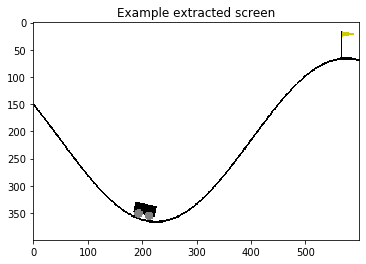

In [0]:
env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
plt.title('Example extracted screen')
plt.show()

In [0]:
BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TARGET_UPDATE = 10
ACTOR_LR = 0.01
CRITIC_LR = 0.01
MEMORY_SIZE = 10000
EPISODE_SIZE = 2000
TAU = 0.005

# gym 행동 공간에서 행동의 숫자를 얻습니다.
n_actions = env.action_space.n
n_obvs = 2

actor = Actor(n_obvs, n_actions).to(device)
actor.eval()
actor_target = Actor(n_obvs, n_actions).to(device)
actor_target.load_state_dict(actor.state_dict())
actor_target.eval()

critic = Critic(n_obvs, n_actions).to(device)
critic.eval()
critic_target = Critic(n_obvs, n_actions).to(device)
critic_target.load_state_dict(critic.state_dict())
critic_target.eval()

actor_optimizer = optim.Adam(actor_net.parameters(), lr=ACTOR_LR)
critic_optimizer = optim.Adam(critic_net.parameters(), lr=CRITIC_LR)
memory = ReplayMemory(MEMORY_SIZE)


steps_done = 0

def select_action(obs):
    global steps_done
    sample = random.random()
    steps_done += 1
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            obs = torch.FloatTensor(obs).to(device)
            output = actor_net(obs).cpu()
            predicted = np.argmax(output.data.numpy())
            return torch.tensor([[predicted]],device=device, dtype=torch.long)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

In [0]:
def target_soft_update(self):
        #Soft-update: target = tau*local + (1-tau)*target
        tau = self.tau
        
        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
            
        for t_param, l_param in zip(
            self.critic_target.parameters(), self.critic.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return -1
    samples = memory.sample()
    state = torch.FloatTensor(samples["obs"]).to(device)
    next_state = torch.FloatTensor(samples["next_obs"]).to(device)
    action = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
    reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
    done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
    masks = 1 - done
    next_action = self.actor_target(next_state)
    next_value = self.critic_target(next_state, next_action)
    curr_return = reward + self.gamma * next_value * masks
        
    # train critic
    values = self.critic(state, action)
    critic_loss = F.mse_loss(values, curr_return)
        
    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()
                
    # train actor
    actor_loss = -self.critic(state, self.actor(state)).mean()
        
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()
        
    # target update
    target_soft_update()

    return actor_loss.data, critic_loss.data

0 episode , 200 step , -1.00 Loss, 0.82 Threshold , -0.31 Top reward
1 episode , 200 step , -0.27 Loss, 0.75 Threshold , -0.43 Top reward
2 episode , 200 step , 0.00 Loss, 0.68 Threshold , -0.29 Top reward
3 episode , 200 step , 0.00 Loss, 0.62 Threshold , -0.45 Top reward
4 episode , 200 step , 0.00 Loss, 0.57 Threshold , -0.48 Top reward
5 episode , 200 step , 0.00 Loss, 0.52 Threshold , -0.45 Top reward
6 episode , 200 step , 0.00 Loss, 0.47 Threshold , -0.40 Top reward
7 episode , 200 step , 0.00 Loss, 0.43 Threshold , -0.47 Top reward
8 episode , 200 step , 0.00 Loss, 0.40 Threshold , -0.43 Top reward
9 episode , 200 step , 0.00 Loss, 0.36 Threshold , -0.40 Top reward
10 episode , 200 step , 0.00 Loss, 0.33 Threshold , -0.35 Top reward
11 episode , 200 step , 0.01 Loss, 0.31 Threshold , -0.40 Top reward
12 episode , 200 step , 0.00 Loss, 0.28 Threshold , -0.41 Top reward
13 episode , 200 step , 0.00 Loss, 0.26 Threshold , -0.39 Top reward
14 episode , 200 step , 0.00 Loss, 0.24 Th

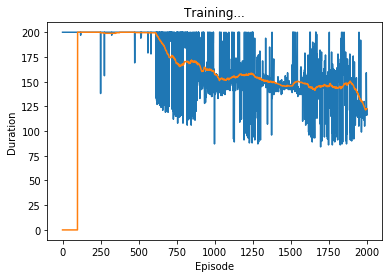

In [0]:
num_episodes = EPISODE_SIZE
for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    obv = env.reset()
    total_loss = 0
    global steps_done
    top_reward = -1
    for t in count():
        # 행동 선택과 수행
        action = select_action(obv)
        next_obv, reward, done, _ = env.step(action.item())
        reward  = obv[0]
        if reward > top_reward:
          top_reward = reward
        if done :
          if t != 199:
            reward += 100
            print('success')
        reward = torch.tensor([reward], device=device)

        if not done:
          next_state = torch.FloatTensor([next_obv])
        else:
          next_state = None
        # 메모리에 변이 저장
        assert obv is not None
        memory.push(torch.FloatTensor([obv]), action, next_state, reward)

        # 다음 상태로 이동
        obv = next_obv

        # 최적화 한단계 수행(목표 네트워크에서)
        total_loss += optimize_model()
        if done:
            E = eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
            episode_durations.append(t + 1)
            print('%d episode , %d step , %.2f Loss, %.2f Threshold , %.2f Top reward'%(i_episode,t+1,total_loss/(t+1),E, top_reward))
            plot_durations()
            total_loss = 0
            top_reward = 0
            break
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.show()